In [ ]:
# Bearings Only Tracking (BOT) demonstration with various filters

# Description:
# In this example various Kalman filters and Rauch-Tung-Striebel
# smoothers are used to estimate the position and velocity of a
# moving object on a plane. Two sensors track the position of the 
# object by returning noisy measurements of angular direction of the 
# target. The methods used are:
#     * Extended Kalman filter (1st and 2nd degree)
#     * Unscented Kalman filter
#     * Gauss-Hermite Kalman filter (degree 3)
#     * Cubature Kalman filter
# Additionally, the corresponding Rauch-Tung-Striebel smoother results 
# are also presented.

# References:
# Refer to the Toolbox documentation for details on the model.

# See also:
# ukf_predict1, ukf_update1, urts_smooth1,
# ekf_predict1, ekf_update1, erts_smooth1, ekf_predict2, ekf_update2,
# ghkf_predict, ghkf_update, ghrts_smooth, 
# ckf_predict, ckf_update, crts_smooth

# Author:
# Copyright (C) 2002, 2003 Simo Särkkä
#                 2007       Jouni Hartikainen
#                 2010       Arno Solin

# Licence:
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

In [2]:
import numpy as np
from numpy import sin, cos, arctan2
from numpy.linalg import inv
from scipy.linalg import expm

import plotly.graph_objects as go
from ipywidgets import interact

import os, sys
sys.path.append('../..')

from bot_h import bot_h
from bot_dh_dx import bot_dh_dx
from bot_d2h_dx2 import bot_d2h_dx2
from der_check import der_check
from lti_disc import lti_disc

from ekf_predict1 import ekf_predict1
from ekf_update1 import ekf_update1
from ekf_update2 import ekf_update2
from erts_smooth1 import erts_smooth1
from etf_smooth1 import etf_smooth1

from ukf_predict1 import ukf_predict1
from ukf_update1 import ukf_update1
from urts_smooth1 import urts_smooth1
from utf_smooth1 import utf_smooth1

from ghkf_predict import ghkf_predict
from ghkf_update import ghkf_update
from ghrts_smooth import ghrts_smooth

from ckf_predict import ckf_predict
from ckf_update import ckf_update
from crts_smooth import crts_smooth

In [3]:
# Set parameters

silent = False

In [4]:
## Simulate trajectory

# Measurement mean and derivative
#
#  h = atan((y-sy) / (x-sx))
h_func = bot_h
dh_dx_func = bot_dh_dx
d2h_dx2_func = bot_d2h_dx2

# Create a bit curved trajectory and angle
# measurements from two sensors
S1 = [-1,-2]
S2 = [1, 1]
sd = 0.05
dt = 0.01

# Acceleration for the target to have a curved trajectory  
a = np.zeros(500)
a[49:100]  = np.pi/2/51/dt + 0.01*np.random.normal(size=51)
a[199:250] = np.pi/2/51/dt + 0.01*np.random.normal(size=51)
a[349:400] = np.pi/2/51/dt + 0.01*np.random.normal(size=51)

x = np.array([0,0,1,0], dtype=float)
T = np.arange(dt,500+dt, dt)
X = np.empty((500,len(x)))
Y = np.empty((500,2,1))
for i in range(500):
    F = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, a[i]],
                  [0, 0, -a[i], 0]])
    x = expm(F*dt)@x
    y1 = arctan2(x[1]-S1[1], x[0]-S1[0]) + sd * np.random.normal()
    y2 = arctan2(x[1]-S2[1], x[0]-S2[0]) + sd * np.random.normal()
    X[i] = x
    Y[i] = [[y1], [y2]]

In [5]:
# Prior for position and velocity
M0 = np.zeros((4,1))
P0 = np.diag([0.1, 0.1, 10, 10])
R = sd**2

m_ = M0.shape[0]
y_ = len(Y)

# Discretize the continous model
qx = 0.1
qy = 0.1

F = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])

A, Q = lti_disc(F, None, np.diag([0, 0, qx, qy]), dt)

## EKF1 & EKF2
---
In this demonstration we track a moving object with two sensors, which gives only bearings of the object with respect to sensors position.
<br>
The state of the system is estimated with 1st and 2nd order EKF, and UKF.

Running 1st order EKF...

In [6]:
###############################################################################
# Initialize EKF1
###############################################################################

M = M0
P = P0
# if not silent:
#     der_check(h_func, dh_dx_func, 1, M, np.matrix(S1).T, nargout=0)
#     der_check(h_func, dh_dx_func, 1, M, np.matrix(S2).T, nargout=0)

MM_EKF1 = np.zeros((y_, m_, 1))
PP_EKF1 = np.zeros((y_, m_, m_))
ME_EKF1 = np.zeros(y_)

# Filter with EKF1
for k in range(y_): 
    M, P = ekf_predict1(M, P, A, Q)
    M, P, *_ = ekf_update1(M, P, Y[k], dh_dx_func, R*np.eye(2), h_func, None, np.column_stack([S1, S2]))
    MM_EKF1[k] = M
    PP_EKF1[k] = P
    ME_EKF1[k] = P[0,0] + P[1,1]

# RMSE for EKF1
ekf1_rmse = np.sqrt(np.mean((X[:,0]-MM_EKF1[:,0,0])**2 + (X[:,1]-MM_EKF1[:,1,0])**2))

In [7]:
# ERTS smoother
SM1_EKF1, SP1_EKF1, _ = erts_smooth1(MM_EKF1, PP_EKF1, A, Q)
eks1_rmse1 = np.sqrt(np.mean((X[:,0]-SM1_EKF1[:,0,0])**2 + (X[:,1]-SM1_EKF1[:,1,0])**2))
ME1_EKF1 = SP1_EKF1[:,0,0] + SP1_EKF1[:,1,1]

# ETF smoother
SM2_EKF1, SP2_EKF1 = etf_smooth1(MM_EKF1,PP_EKF1,Y,A,Q, None, None, None,
                dh_dx_func, R*np.eye(2), h_func, None, np.column_stack([S1, S2]))
eks1_rmse2 = np.sqrt(np.mean((X[:,0]-SM2_EKF1[:,0,0])**2 + (X[:,1]-SM2_EKF1[:,1,0])**2))
ME2_EKF1 = SP2_EKF1[:,0,0] + SP2_EKF1[:,1,1]

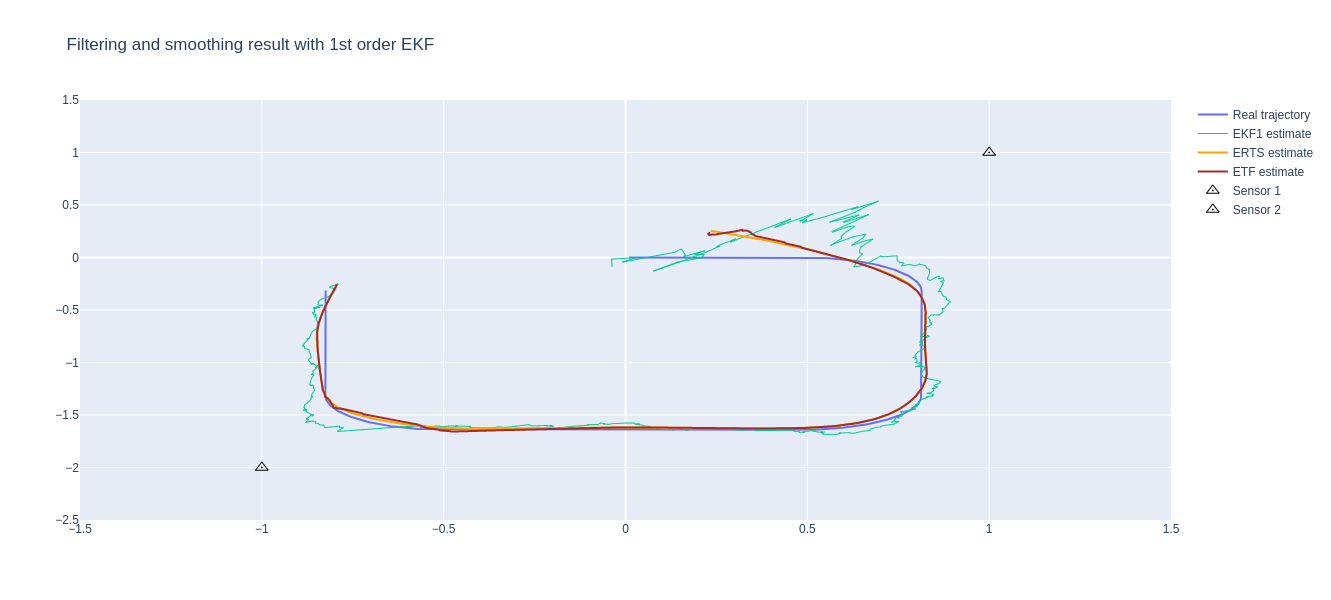

In [8]:
# Plot the results
if not silent:
    fig = go.Figure()
    fig.add_scatter(x=X[:,0], y=X[:,1], name='Real trajectory')
    fig.add_scatter(x=MM_EKF1[:,0,0], y=MM_EKF1[:,1,0], line_width=1, line_color='#00CC96', name='EKF1 estimate')
    fig.add_scatter(x=SM1_EKF1[:,0,0], y=SM1_EKF1[:,1,0], line_color='orange', name='ERTS estimate')
    fig.add_scatter(x=SM2_EKF1[:,0,0], y=SM2_EKF1[:,1,0], line_color='brown', name='ETF estimate')
    fig.add_scatter(x=[S1[0]], y=[S1[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 1')
    fig.add_scatter(x=[S2[0]], y=[S2[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 2')
    fig.layout.update(title='Filtering and smoothing result with 1st order EKF', 
                      xaxis_range=[-1.5, 1.5], yaxis_range=[-2.5, 1.5], height=600)
    fig.show()

In [9]:
###############################################################################
# Initialize EKF2
###############################################################################

M = M0
P = P0
# if not silent:
#     der_check(h_func, d2h_dx2_func, 1, M, np.matrix(S1).T, nargout=0)
#     der_check(h_func, d2h_dx2_func, 1, M, np.matrix(S2).T, nargout=0)

MM_EKF2 = np.zeros((y_, m_, 1))
PP_EKF2 = np.zeros((y_, m_, m_))
ME_EKF2 = np.zeros(y_)

# Filter with EKF2
for k in range(y_):
    M, P = ekf_predict1(M, P, A, Q)
    M, P, *_ = ekf_update2(M, P, Y[k], dh_dx_func, d2h_dx2_func, R*np.eye(2), h_func, None, np.column_stack([S1, S2]))
    MM_EKF2[k] = M
    PP_EKF2[k] = P
    ME_EKF2[k] = P[0,0] + P[1,1]

ekf2_rmse = np.sqrt(np.mean((X[:,0]-MM_EKF2[:,0,0])**2 + (X[:,1]-MM_EKF2[:,1,0])**2))

In [10]:
###############################################################################
# Smoother 1
###############################################################################
SM1_EKF2, SP1_EKF2, _ = erts_smooth1(MM_EKF2, PP_EKF2, A, Q)
eks2_rmse1 = np.sqrt(np.mean((X[:,0]-SM1_EKF2[:,0,0])**2 + (X[:,1]-SM1_EKF2[:,1,0])**2))
ME1_EKF2 = SP1_EKF2[:,0,0] + SP1_EKF2[:,1,1]

###############################################################################
# Smoother 2
###############################################################################
SM2_EKF2, SP2_EKF2 = etf_smooth1(MM_EKF2, PP_EKF2, Y, A, Q, None, None, None,
                                 dh_dx_func, R*np.eye(2), h_func, None, np.column_stack([S1, S2]))
eks2_rmse2 = np.sqrt(np.mean((X[:,0]-SM2_EKF2[:,0,0])**2 + (X[:,1]-SM2_EKF2[:,1,0])**2))
ME2_EKF2 = SP2_EKF2[:,0,0] + SP2_EKF2[:,1,1]

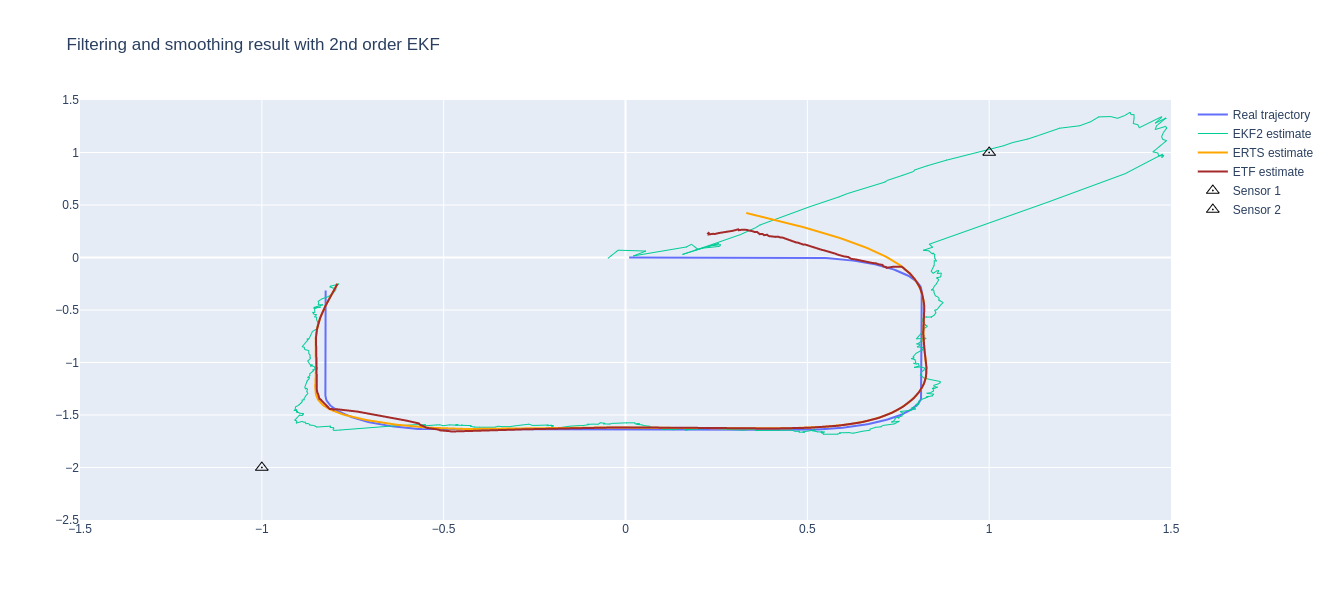

In [11]:
# Plot the results
if not silent:
    fig = go.Figure()
    fig.add_scatter(x=X[:,0], y=X[:,1], name='Real trajectory')
    fig.add_scatter(x=MM_EKF2[:,0,0], y=MM_EKF2[:,1,0], line_width=1, line_color='#00CC96', name='EKF2 estimate')
    fig.add_scatter(x=SM1_EKF2[:,0,0], y=SM1_EKF2[:,1,0], line_color='orange', name='ERTS estimate')
    fig.add_scatter(x=SM2_EKF2[:,0,0], y=SM2_EKF2[:,1,0], line_color='brown', name='ETF estimate')
    fig.add_scatter(x=[S1[0]], y=[S1[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 1')
    fig.add_scatter(x=[S2[0]], y=[S2[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 2')
    fig.layout.update(title='Filtering and smoothing result with 2nd order EKF', 
                      xaxis_range=[-1.5, 1.5], yaxis_range=[-2.5, 1.5], height=600)
    fig.show()

## UKF
---

In [12]:
# Initialize UKF
M = M0
P = P0

MM_UKF = np.zeros((y_, m_, 1))
PP_UKF = np.zeros((y_, m_, m_))
ME_UKF = np.zeros(y_)

# Filter with UKF
for k in range(y_):
    M, P, _ = ukf_predict1(M, P, A, Q)
    M, P, *_ = ukf_update1(M, P, Y[k], h_func, R*np.eye(2), np.column_stack([S1, S2]))
    MM_UKF[k] = M
    PP_UKF[k] = P
    ME_UKF[k] = P[0,0] + P[1,1]

# Calculate RMSE of UKF
ukf_rmse = np.sqrt(np.mean((X[:,0]-MM_UKF[:,0,0])**2 + (X[:,1]-MM_UKF[:,1,0])**2))

In [13]:
# URTS Smoother   
SM1_UKF, SP1_UKF, _ = urts_smooth1(MM_UKF, PP_UKF, A, Q)
uks_rmse1 = np.sqrt(np.mean((X[:,0]-SM1_UKF[:,0,0])**2 + (X[:,1]-SM1_UKF[:,1,0])**2))
ME1_UKF = SP1_UKF[:,0,0] + SP1_UKF[:,1,1]

# UTF Smoother
IAW = inv(A)@np.hstack([np.eye(A.shape[0]), np.eye(A.shape[0])])
SM2_UKF, SP2_UKF = utf_smooth1(MM_UKF, PP_UKF, Y, IAW, Q, None, h_func, R*np.eye(2), np.column_stack([S1, S2]))
uks_rmse2 = np.sqrt(np.mean((X[:,0]-SM2_UKF[:,0,0])**2 + (X[:,1]-SM2_UKF[:,1,0])**2))
ME2_UKF = SP2_UKF[:,0,0] + SP2_UKF[:,1,1]

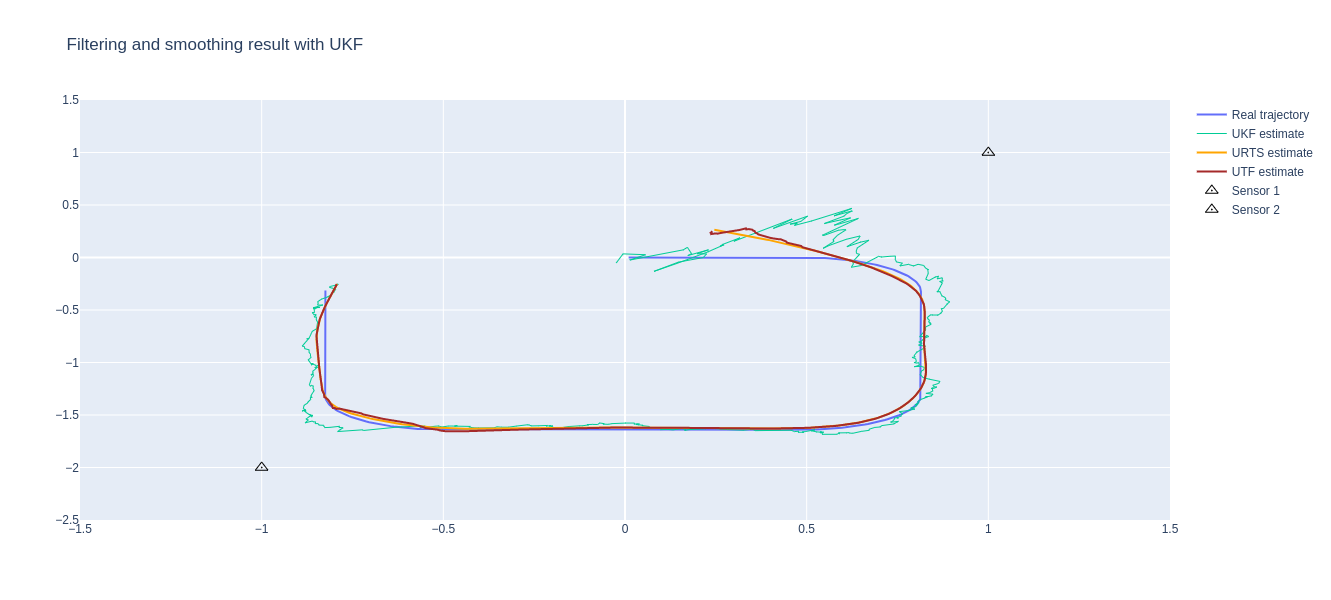

In [14]:
# Plot UKF, URTS, UTF
if not silent:
    fig = go.Figure()
    fig.add_scatter(x=X[:,0], y=X[:,1], name='Real trajectory')
    fig.add_scatter(x=MM_UKF[:,0,0], y=MM_UKF[:,1,0], line_width=1, line_color='#00CC96', name='UKF estimate')
    fig.add_scatter(x=SM1_UKF[:,0,0], y=SM1_UKF[:,1,0], line_color='orange', name='URTS estimate')
    fig.add_scatter(x=SM2_UKF[:,0,0], y=SM2_UKF[:,1,0], line_color='brown', name='UTF estimate')
    fig.add_scatter(x=[S1[0]], y=[S1[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 1')
    fig.add_scatter(x=[S2[0]], y=[S2[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 2')
    fig.layout.update(title='Filtering and smoothing result with UKF', 
                      xaxis_range=[-1.5, 1.5], yaxis_range=[-2.5, 1.5], height=600)
    fig.show()

## GHKF
---

In [15]:
# Initialize GHKF
M = M0
P = P0

MM_GHKF = np.zeros((y_, m_, 1))
PP_GHKF = np.zeros((y_, m_, m_))
ME_GHKF = np.zeros(y_)

# Filter with GHKF
for k in range(y_):
    M, P = ghkf_predict(M, P, A, Q, None, 3)
    M, P, *_ = ghkf_update(M, P, Y[k], h_func, R*np.eye(2), np.column_stack([S1, S2]), 3)
    MM_GHKF[k] = M
    PP_GHKF[k] = P
    ME_GHKF[k] = P[0,0] + P[1,1]

# Calculate RMSE of GHKF
ghkf_rmse = np.sqrt(np.mean((X[:,0]-MM_GHKF[:,0,0])**2 + (X[:,1]-MM_GHKF[:,1,0])**2))

In [16]:
# GHRTS Smoother   
SM1_GHKF, SP1_GHKF, _ = ghrts_smooth(MM_GHKF, PP_GHKF, A, Q, None, 3)
ghks_rmse1 = np.sqrt(np.mean((X[:,0]-SM1_GHKF[:,0,0])**2 + (X[:,1]-SM1_GHKF[:,1,0])**2))
ME1_GHKF = SP1_GHKF[:,0,0] + SP1_GHKF[:,1,1]

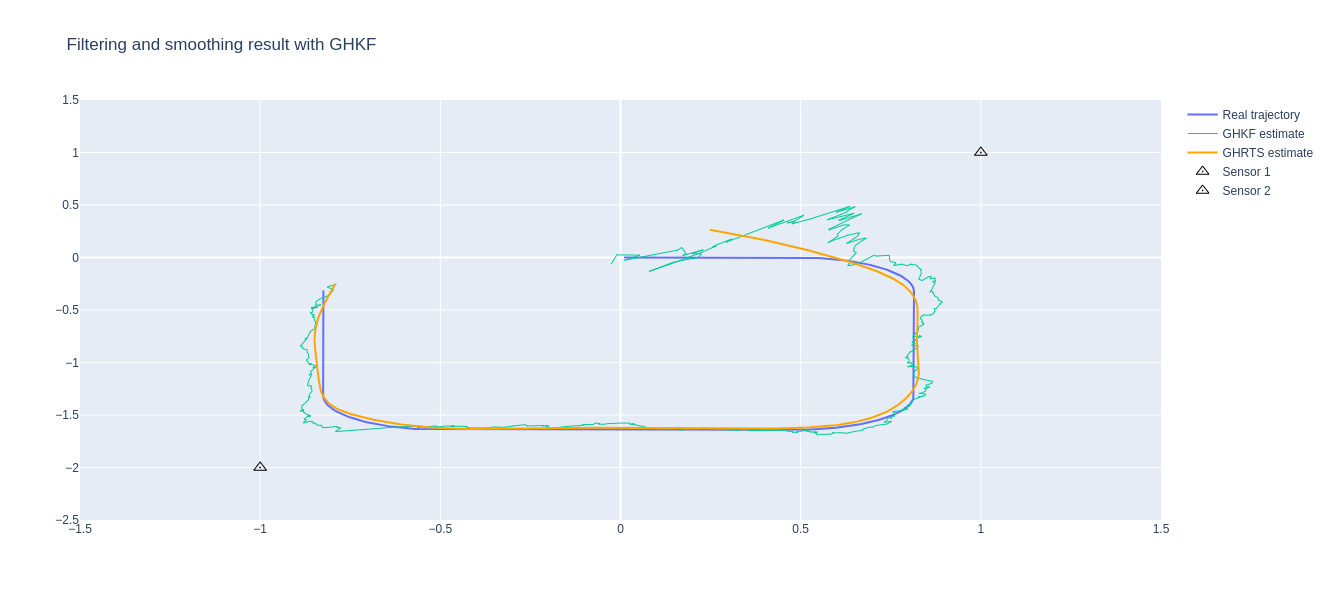

In [17]:
# Plot GHKF, GHRTS
if not silent:
    fig = go.Figure()
    fig.add_scatter(x=X[:,0], y=X[:,1], name='Real trajectory')
    fig.add_scatter(x=MM_GHKF[:,0,0], y=MM_GHKF[:,1,0], line_width=1, line_color='#00CC96', name='GHKF estimate')
    fig.add_scatter(x=SM1_GHKF[:,0,0], y=SM1_GHKF[:,1,0], line_color='orange', name='GHRTS estimate')
    fig.add_scatter(x=[S1[0]], y=[S1[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 1')
    fig.add_scatter(x=[S2[0]], y=[S2[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 2')
    fig.layout.update(title='Filtering and smoothing result with GHKF', 
                      xaxis_range=[-1.5, 1.5], yaxis_range=[-2.5, 1.5], height=600)
    fig.show()

## CKF
---

In [18]:
# Initialize CKF
M = M0
P = P0
MM_CKF = np.zeros((y_, m_, 1))
PP_CKF = np.zeros((y_, m_, m_))
ME_CKF = np.zeros(y_)

# Filter with CKF
for k in range(y_):
    M, P = ckf_predict(M, P, A, Q, None)
    M, P, *_ = ckf_update(M, P, Y[k], h_func, R*np.eye(2), np.column_stack([S1, S2]))
    MM_CKF[k] = M
    PP_CKF[k] = P
    ME_CKF[k] = P[0,0] + P[1,1]

# Calculate RMSE of CKF
ckf_rmse = np.sqrt(np.mean((X[:,0]-MM_CKF[:,0,0])**2 + (X[:,1]-MM_CKF[:,1,0])**2))

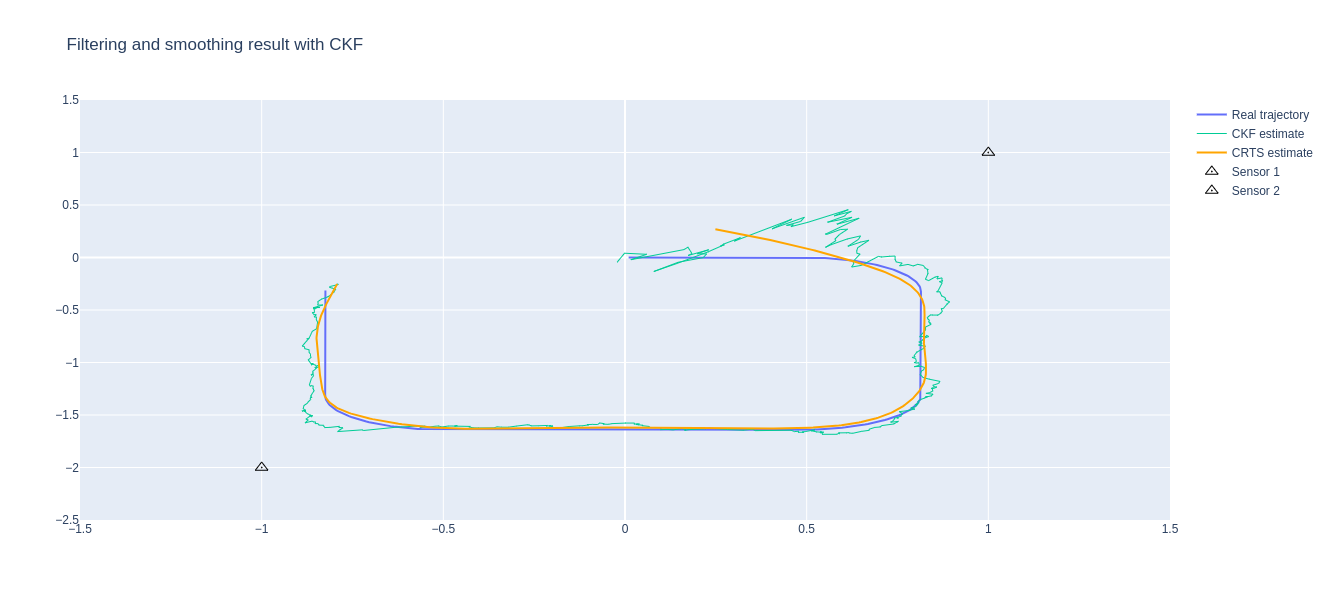

In [19]:
# CRTS Smoother   
SM1_CKF, SP1_CKF, _ = crts_smooth(MM_CKF, PP_CKF, A, Q, None)
cks_rmse1 = np.sqrt(np.mean((X[:,0]-SM1_CKF[:,0,0])**2 + (X[:,1]-SM1_CKF[:,1,0])**2))
ME1_CKF = SP1_CKF[:,0,0] + SP1_CKF[:,1,1]




# Plot CKF, CRTS
if not silent:
    fig = go.Figure()
    fig.add_scatter(x=X[:,0], y=X[:,1], name='Real trajectory')
    fig.add_scatter(x=MM_CKF[:,0,0], y=MM_CKF[:,1,0], line_width=1, line_color='#00CC96', name='CKF estimate')
    fig.add_scatter(x=SM1_CKF[:,0,0], y=SM1_CKF[:,1,0], line_color='orange', name='CRTS estimate')
    fig.add_scatter(x=[S1[0]], y=[S1[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 1')
    fig.add_scatter(x=[S2[0]], y=[S2[1]], mode='markers', marker=dict(symbol='triangle-up-open-dot', color='black', size=11), name='Sensor 2')
    fig.layout.update(title='Filtering and smoothing result with CKF', 
                      xaxis_range=[-1.5, 1.5], yaxis_range=[-2.5, 1.5], height=600)
    fig.show()

In [20]:
## Show RMSE values for all methods
print('EKF1-RMSE = {:4f}\t[{:4f}]'.format(*[ekf1_rmse, np.sqrt(np.mean(ME_EKF1))]))
print('ERTS1-RMSE = {:4f}\t[{:4f}]'.format(*[eks1_rmse1, np.sqrt(np.mean(ME1_EKF1))]))
print('ETF1-RMSE = {:4f}\t[{:4f}]'.format(*[eks1_rmse2, np.sqrt(np.mean(ME2_EKF1))]))
print('EKF2-RMSE  = {:4f}\t[{:4f}]'.format(*[ekf2_rmse,  np.sqrt(np.mean(ME_EKF2))]))
print('ERTS2-RMSE = {:4f}\t[{:4f}]'.format(*[eks2_rmse1, np.sqrt(np.mean(ME1_EKF2))]))
print('ETF2-RMSE  = {:4f}\t[{:4f}]'.format(*[eks2_rmse2, np.sqrt(np.mean(ME2_EKF2))]))
print('UKF-RMSE   = {:4f}\t[{:4f}]'.format(*[ukf_rmse,   np.sqrt(np.mean(ME_UKF))]))
print('URTS-RMSE  = {:4f}\t[{:4f}]'.format(*[uks_rmse1,  np.sqrt(np.mean(ME1_UKF))]))
print('UTF-RMSE   = {:4f}\t[{:4f}]'.format(*[uks_rmse2,  np.sqrt(np.mean(ME2_UKF))]))
print('GHKF-RMSE  = {:4f}\t[{:4f}]'.format(*[ghkf_rmse,   np.sqrt(np.mean(ME_GHKF))]))
print('GHRTS-RMSE = {:4f}\t[{:4f}]'.format(*[ghks_rmse1,  np.sqrt(np.mean(ME1_GHKF))]))
print('CKF-RMSE   = {:4f}\t[{:4f}]'.format(*[ckf_rmse,   np.sqrt(np.mean(ME_CKF))]))
print('CRTS-RMSE  = {:4f}\t[{:4f}]'.format(*[cks_rmse1,  np.sqrt(np.mean(ME1_CKF))]))

EKF1-RMSE = 0.132300	[0.100302]
ERTS1-RMSE = 0.075985	[0.036032]
ETF1-RMSE = 0.079676	[0.034683]
EKF2-RMSE  = 0.452071	[0.188053]
ERTS2-RMSE = 0.126656	[0.037550]
ETF2-RMSE  = 0.084513	[0.035080]
UKF-RMSE   = 0.125588	[0.098593]
URTS-RMSE  = 0.078756	[0.036000]
UTF-RMSE   = 0.083410	[0.034733]
GHKF-RMSE  = 0.133203	[0.097085]
GHRTS-RMSE = 0.079220	[0.035743]
CKF-RMSE   = 0.125884	[0.096879]
CRTS-RMSE  = 0.079717	[0.035791]
